
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/master?urlpath=lab/tree/exclusion_mask.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/docs/tutorials).
- **Source files:**
[exclusion_mask.ipynb](../_static/notebooks/exclusion_mask.ipynb) |
[exclusion_mask.py](../_static/notebooks/exclusion_mask.py)
</div>


# Creating exclusion masks

## Introduction

### Prerequisites

- Understanding of basic analyses in 1D or 3D.
- Usage of `~regions` and catalogs, see the [catalog notebook](catalog.ipynb). 

### Context

Background templates stored in the DL3 IRF are often not reliable enough to be used without some corrections. A set of common techniques to perform background or normalisation from the data is implemented in gammapy: reflected regions for 1D spectrum analysis, field-of-view (FoV) background or ring background for 2D and 3D analyses.

To avoid contamination of the background estimate from gamma-ray bright regions these methods require to exclude those regions from the data used for the estimation. To do so, we use exclusion masks. They are maps containing boolean values where excluded pixels are stored as False.  

**Objective: Build an exclusion mask around the Crab nebula excluding gamma-ray sources in the region.**

### Proposed approach

Here we have to build a `Map` object, we must first define its geometry and then we can determine which pixels to exclude.

We can rely on known sources positions and properties to build a list of regions (here `~regions.SkyRegions`) enclosing most of the signal that our detector would see from these objects. We show below how to build this list manually or from an existing catalog. 

Finally, we show how to build the mask from a `MapDataset`, finding pixels which contain statistically significant signal. To do so, we use the `ExcessMapEstimator`
 

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.maps import Map, WcsGeom
from gammapy.utils.regions import make_region
from gammapy.catalog import CATALOG_REGISTRY
from gammapy.datasets import Datasets
from gammapy.estimators import ExcessMapEstimator

## Create the mask from a list of regions

One can build an exclusion mask from regions. We show here how to proceed.

### Define the geometry

Exclusions masks are stored in `Map` objects. One has therefore to define the geometry to use. Here we consider a region at the Galactic anticentre around the crab nebula.

In [3]:
position = SkyCoord(83.633083, 22.0145, unit="deg", frame="icrs")
geom = WcsGeom.create(
    skydir=position, width="5 deg", binsz=0.02, frame="galactic"
)

### Create the list of regions

A useful function to create region objects is `~gammapy.utils.regions.make_region`. It can take strings defining regions following the "ds9" format and convert them to `regions`. 

Here we use a region enclosing the Crab nebula with 0.3 degrees. The actual region size should depend on the expected PSF of the data used. We also add another region with a different shape as en example.

In [4]:
some_region = make_region("galactic;box(185,-4,1.0,0.5, 45)")
crab_region = make_region("icrs;circle(83.633083, 22.0145, 0.3)")
regions = [some_region, crab_region]
print(regions)

[<RectangleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    (185., -4.)>, width=1.0 deg, height=0.5 deg, angle=45.0 deg)>, <CircleSkyRegion(<SkyCoord (ICRS): (ra, dec) in deg
    (83.633083, 22.0145)>, radius=0.3 deg)>]


Equivalently the regions can be read from a ds9 file, this time using `regions.read_ds9`. 

In [5]:
# regions = read_ds9('ds9.reg')

### Create the mask map 

We can now create the map. We use the `WcsGeom.region_mask` method putting all pixels inside the regions to False.

In [6]:
mask_data = geom.region_mask(regions, inside=False)
mask_map = Map.from_geom(geom, data=mask_data)

(<Figure size 432x288 with 1 Axes>,
 <WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 None)

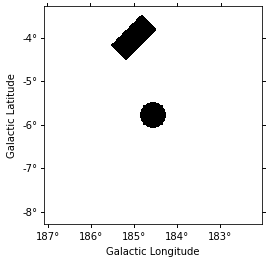

In [7]:
mask_map.plot()

## Create the mask from a catalog of sources

We can also build our list of regions from a list of catalog sources. Here we use the Fermi 4FGL catalog which we read using `~gammapy.catalog.SourceCatalog`.

In [8]:
fgl = CATALOG_REGISTRY.get_cls("4fgl")()

We now select sources that are contained in the region we are interested in.

In [9]:
inside_geom = geom.contains(fgl.positions)
idx = np.where(inside_geom)[0]

We now create the list of regions using our 0.3 degree radius a priori value. If the sources were extended, one would have to adapt the sizes to account for the larger size.

In [10]:
exclusion_radius = Angle("0.3 deg")
regions = [CircleSkyRegion(fgl[i].position, exclusion_radius) for i in idx]

Now we can build the mask map the same way as above.

In [11]:
mask_data = geom.region_mask(regions, inside=False)
mask_map_catalog = Map.from_geom(geom, data=mask_data)

(<Figure size 432x288 with 1 Axes>,
 <WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 None)

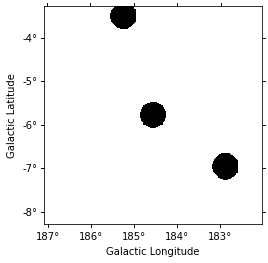

In [12]:
mask_map_catalog.plot()

### Combining masks

If two masks share the same geometry it is easy to combine them with `Map` arithmetics.

(<Figure size 432x288 with 1 Axes>,
 <WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 None)

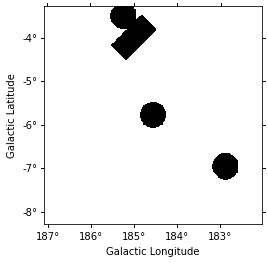

In [13]:
mask_map *= mask_map_catalog
mask_map.plot()

## Create the mask from statistically significant pixels in a dataset

Here we want to determine an exclusion from the data directly. We will estimate the significance of the data and exclude all pixels above a given threshold.

Here we use a dataset taken from Fermi data used in the 3FHL catalog. The dataset is already in the form of a `Datasets` object. We read it from disk. 

In [14]:
datasets = Datasets.read(
    "$GAMMAPY_DATA/fermi-3fhl-crab/",
    "Fermi-LAT-3FHL_datasets.yaml",
    "Fermi-LAT-3FHL_models.yaml",
)

We want to compute the significance per pixels for the data integrated over energy. We reduce the dataset to a simple image. 

In [15]:
dataset = datasets[0].to_image()

We now apply a significance estimation. We integrate the counts using a correlation radius of 0.4 degree and apply regular significance estimate. 

In [16]:
estimator = ExcessMapEstimator("0.4 deg", selection_optional=[])
result = estimator.run(dataset)

Finally, we create the mask map by applying a threshold of 5 sigma to remove pixels.

In [17]:
mask_map_significance = result["significance"] < 5.0

(<Figure size 432x288 with 1 Axes>,
 <WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 None)

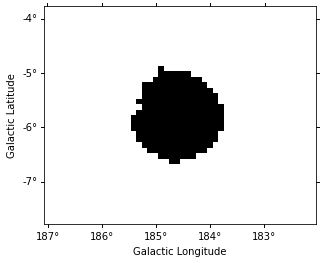

In [18]:
mask_map_significance.sum_over_axes().plot()

This method frequently yields isolated pixels or weakly significant features if one places the threshold too low. 

To overcome this issue, one can use `~skimage.filters.apply_hysteresis_threshold` . This filter allows to define two thresholds and mask only the pixels between the low and high thresholds if they are not continuously connected to a pixel above the high threshold. This allows to better preserve the structure of the excesses. 

Note that scikit-image is not a required dependency of gammapy, you might need to install it.


## Reading and writing exclusion masks

`gammapy.maps` cannot directly read/write maps with boolean content. Thus, for serialisation of exclusion masks, it is necessary to do an explicit type casting between boolean and int, as we show here.

In [19]:
# To save masks to disk
mask_map_int = mask_map.copy()
mask_map_int.data = mask_map_int.data.astype(int)
mask_map_int.write("exclusion_mask.fits", overwrite="True")

In [20]:
# To read maps from disk
mask_map = Map.read("exclusion_mask.fits")
mask_map.data = mask_map.data.astype(bool)